In [1]:
import MeCab
import codecs
import urllib
import urllib.parse as parser
import urllib.request as request
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

from gensim.models import word2vec

import re

mecab = MeCab.Tagger('-Owakati -d /usr/local/mecab/lib/mecab/dic/mecab-ipadic-neologd')
title = MeCab.Tagger('-d /usr/local/mecab/lib/mecab/dic/mecab-ipadic-neologd')

In [2]:
url = "http://lain.gr.jp/voicedb/individual/age/avg/10"
 
response = requests.get(url)
response.encoding = response.apparent_encoding
 
soup10 = BeautifulSoup(response.text, 'html.parser')
 
url = "http://lain.gr.jp/voicedb/individual/age/avg/20"
 
response = requests.get(url)
response.encoding = response.apparent_encoding
 
soup20 = BeautifulSoup(response.text, 'html.parser')

url = "http://lain.gr.jp/voicedb/individual/age/avg/30"
 
response = requests.get(url)
response.encoding = response.apparent_encoding
 
soup30 = BeautifulSoup(response.text, 'html.parser')


In [3]:
# 声優さんの名前のリストを取得する
corpus=[]
name10 = soup10.find_all(href=re.compile("voicedb/profile"))
name20 = soup20.find_all(href=re.compile("voicedb/profile"))
name30 = soup30.find_all(href=re.compile("voicedb/profile"))
for p in name10:
            #corpus.append(m.parse(p.text).strip())
            corpus.append(p.text)
for p in name20:
            #corpus.append(m.parse(p.text).strip())
            corpus.append(p.text)
for p in name30:
            #corpus.append(m.parse(p.text).strip())
            corpus.append(p.text)

In [4]:
# 声優さんの性別を取得する
data = []
for img in soup10.find_all('img'):
    data.append(dict(src=img['src'],
                     alt=img.attrs.get('alt', 'N')))
for img in soup20.find_all('img'):
    data.append(dict(src=img['src'],
                     alt=img.attrs.get('alt', 'N')))
for img in soup30.find_all('img'):
    data.append(dict(src=img['src'],
                     alt=img.attrs.get('alt', 'N')))

gender = []
for res in data:
    for k, v in res.items():
        if v == '女性' or v == '男性':
            gender.append(v)

In [5]:
# スクレイピングで取得した声優リスト情報を保存する。
name = pd.DataFrame(corpus)
gen = pd.DataFrame(gender)
res = pd.concat([name, gen],axis=1)
res.columns = ['Name','Gender']
res.to_csv('seiyu.csv')

In [6]:
df = pd.read_csv('seiyu.csv')


link = "https://ja.wikipedia.org/wiki/"
df_women = df[df.Gender=='女性']
keyword = df_women.Name
#keyword = keyword.to_list()
keyword = list(keyword)
corpus = []
for word in keyword:
    # 声優の記事をダウンロード
    try:
        with request.urlopen(link + parser.quote_plus(word)) as response:
            # responseはhtmlのformatになっている
            html = response.read().decode('utf-8')
            soup = BeautifulSoup(html, "lxml")
            # <p>タグを取得
            p_tags = soup.find_all('p')
            for p in p_tags:
                #corpus.append(tagger.parse(p.text).strip())
                corpus.append(p.text.strip())
    except urllib.error.HTTPError as err:
        # 例外処理に該当した声優さんを表示する
        print(word)
        if err.code == 404:
            continue
        else:
            raise

with codecs.open("pwiki.txt", "w", "utf-8") as f:
    f.write("\n".join(corpus))

404
濱頭優
404
菅あやか
404
大前愛華
404
大山早稀
404
野村唯
404
大友萌
404
小笠原茉莉
404
三村江里
404
ブリドカット セーラ 恵美
404
国仲奏絵
404
太田敦子
404
和田恵未
404
みきもと栞
404
福井智美
404
夏目凜子
404
荒友美
404
藤堂まり
404
平井花海
404
尾張由美子
404
古川かおり
404
有島明日香
404
根来彰子
404
岡美智恵
404
宮本真利
404
相上和音
404
辻愛
404
葛城里美


In [19]:
fi = codecs.open('pwiki.txt')
result = []
fo = open('try.csv', 'w')

lines = fi.readlines()
for line in lines:
    line = re.sub('[\n\r]',"",line)
    line = re.sub('[　]'," ",line) #全角スペースを半角に変換しないと、一部の名詞が複合名詞として抽出できない
    line = re.sub('(年|月|日)',"",line)
    line = re.sub('[0-9_]',"",line)
    line = re.sub('[#]',"",line)
    line = re.sub('[!]',"",line)
    line = re.sub('[*]',"",line)
    fo.write(line + '\n')


fi.close()
fo.close()

In [201]:
fi = open('try.csv', 'r')
fo = open('res.csv', 'w')

#line = fi.readline()
lines = fi.readlines()
result=[]
mecab.parse("")


for line in lines:
    node = mecab.parseToNode(line)
    node_org = title.parse(line)
    
    while node:
        hinshi = node.feature.split(",")[0]
        if hinshi == '形容詞' or hinshi == '名詞' or hinshi == '副詞' or (len(node.feature.split(",")[6])>1):
            fo.write(node.feature.split(",")[6] + ' ')
        if node_org != 'EOS\n' and node_org.split(",")[1] == '固有名詞':
            fo.write(node_org.split(",")[6] + ' ')
        if node_org != 'EOS\n' and node_org.split(",")[1] == '固有名詞' and node_org.split(",")[6].isalpha()==True:
            fo.write(node_org.split(",")[7] + ' ')
        node = node.next

fi.close()
fo.close()

print('Wakati phase completed!')

sentences = word2vec.LineSentence('res.csv')
model = word2vec.Word2Vec(sentences,
                          sg=1,
                          size=200,
                          min_count=5,
                          window=5,
                          hs=1,
                          iter=100,
                          negative=0)


# 折角計算したのでpickleに保存
import pickle
with open('mecab_word2vec_seiyu.dump', mode='wb') as f:
    pickle.dump(model, f)

Wakati phase completed!


/Users/yukihiro-su/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [205]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['font.family'] = 'IPAexGothic'
with open('mecab_word2vec_seiyu.dump', mode='rb') as f:
     model = pickle.load(f)

In [215]:
df = pd.read_csv('seiyu20.csv')
name = df[df.Gender=='女性']
white_list = name.Name

In [217]:
output = []
label = []
for name in white_list:
    try:
        vector = model.wv[name]
        output.append(vector)
        label.append(name)
    except:
        continue
res = np.corrcoef(output)

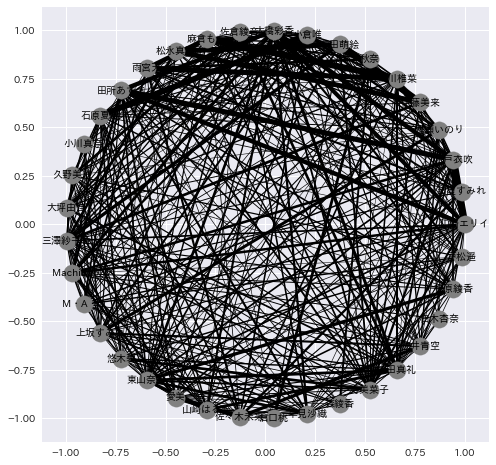

In [220]:
# networkxに引き渡すエッジリストを準備
edge_lists = []
df = pd.DataFrame(res)

edge_name = label
df.index = df.columns = edge_name


# 相関係数DFより右上の三角行列およびに 0.1以下のデータをマスク
tmp_df = df.mask(np.triu(np.ones(df.shape)).astype(bool) | (df < 0.05))
# エッジリストを生成
edge_lists = tmp_df.stack().reset_index().apply(tuple, axis=1).values

G = nx.Graph()
G.add_weighted_edges_from(edge_lists)




# 描画の準備
plt.figure(figsize=(8,8))  #描画対象に合わせて設定する

#np.random.seed(seed=1234)    #ノードポジションの再現性を確保するためseedを設定する
#pos = nx.spring_layout(G)    #ノードのポジションの計算
pos = nx.circular_layout(G)

line_width = [d['weight']*10 for u,v,d in G.edges(data=True)]
nx.draw_networkx(G, pos=pos, font_size=10, node_color='gray', width=line_width, font_family='IPAexGothic')
plt.savefig('netres.png')

In [221]:
print(nx.average_clustering(G))

0.610103228782055


[('大橋彩香', 0.04555164528689211), ('山崎エリイ', 0.039995796742290854), ('木戸衣吹', 0.03944625539215552), ('東山奈央', 0.03748530983574666), ('小倉唯', 0.036855264907774486), ('夏川椎菜', 0.03677562557911518), ('麻倉もも', 0.034883881713288184), ('三澤紗千香', 0.03461691295075832), ('田所あずさ', 0.03458330057908542), ('内田真礼', 0.034217274567621005), ('豊田萌絵', 0.033018028594089754), ('寿美菜子', 0.03235768418454441), ('石原夏織', 0.03065891275211937), ('雨宮天', 0.030072491383579297), ('上坂すみれ', 0.02920698033366847), ('Machico', 0.028396698868023), ('愛美', 0.02759156041213482), ('水瀬いのり', 0.027163302263303015), ('伊藤美来', 0.026500204152951186), ('山崎はるか', 0.02511585403440591)]


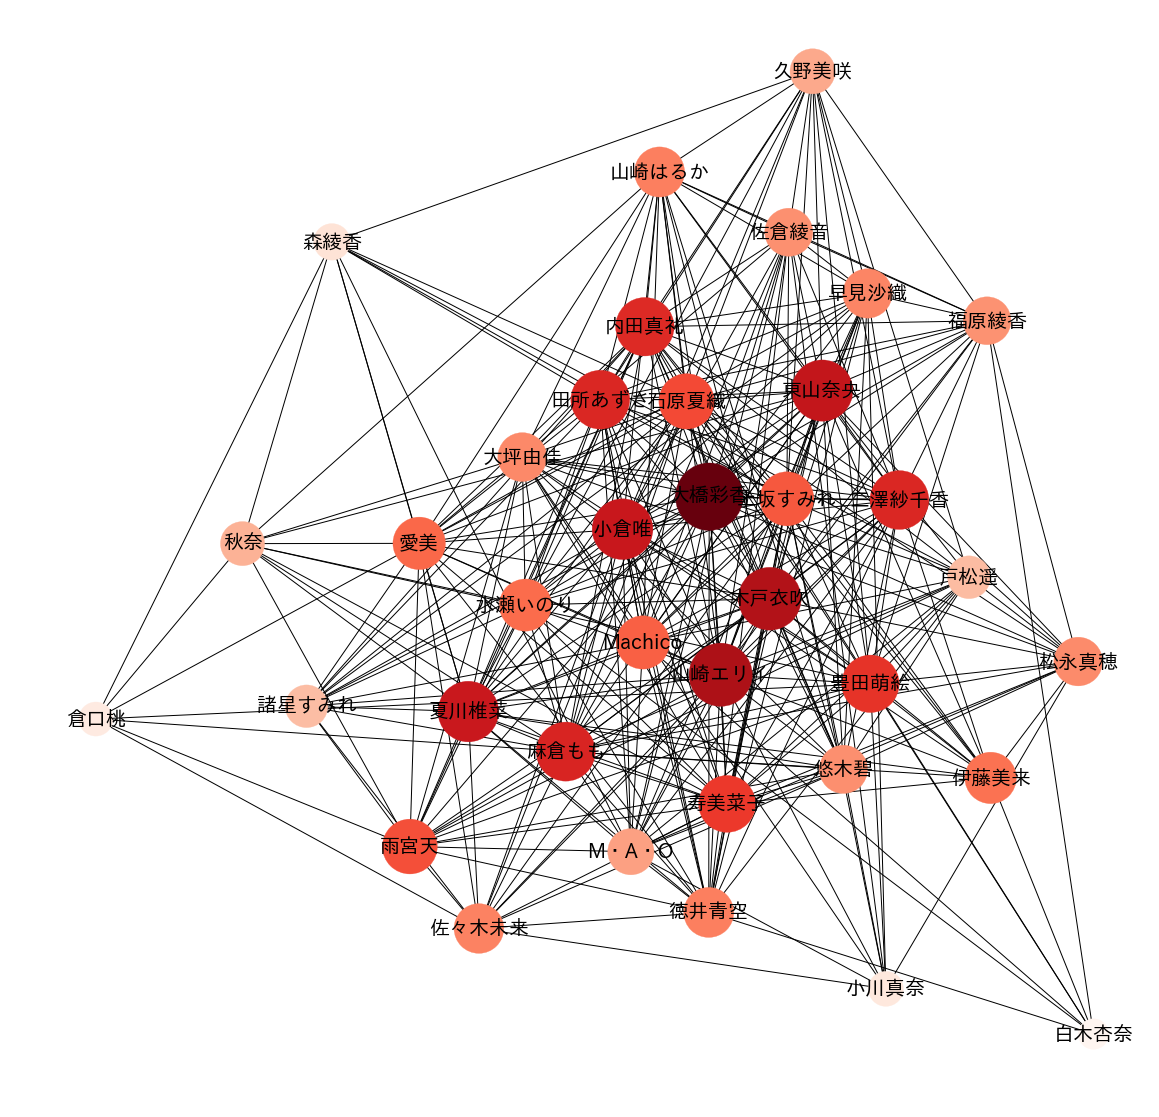

In [244]:
pr = nx.pagerank(G)
pos1 = nx.spring_layout(G)


# 可視化
plt.figure(figsize=(20, 20))
nx.draw_networkx_edges(G, pos1)
nx.draw_networkx_nodes(G, pos=pos1, node_color=list(pr.values()), cmap=plt.cm.Reds, font_family='IPAexGothic', node_size=[100000*v for v in pr.values()])
nx.draw_networkx_labels(G,pos1,font_size=20, font_family='IPAexGothic')

plt.axis('off')
#plt.show()
plt.savefig('figfig.png')

score_sorted = sorted(pr.items(), key=lambda x:-x[1])
print(score_sorted[0:20])

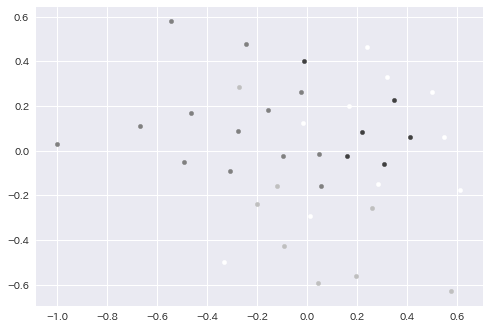

In [225]:
import community
partition = community.best_partition(G)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()):
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20, node_color = str(count/size))
plt.show()

In [226]:
partition = community.best_partition(G)
labels = dict([(i, str(i)) for i in range(nx.number_of_nodes(G))])
nx.set_node_attributes(G, labels,'label')
nx.set_node_attributes(G, partition, 'community')
nx.write_gml(G, "community.gml")
nx.write_graphml(G, "fourpath.graphml", encoding='utf-8')

In [228]:
for k,v in partition.items():
    if int(v)==0:
        print(k)

山崎エリイ
木戸衣吹
大橋彩香
田所あずさ
Machico
M・A・O


In [227]:
for k,v in partition.items():
    if int(v)==1:
        print(k)

諸星すみれ
夏川椎菜
秋奈
麻倉もも
雨宮天
愛美
佐々木未来
倉口桃
森綾香
徳井青空


In [229]:
for k,v in partition.items():
    if int(v)==2:
        print(k)

水瀬いのり
小倉唯
石原夏織
小川真奈
大坪由佳
上坂すみれ


In [230]:
for k,v in partition.items():
    if int(v)==3:
        print(k)

伊藤美来
豊田萌絵
松永真穂
三澤紗千香
悠木碧
寿美菜子
白木杏奈
戸松遥


In [231]:
for k,v in partition.items():
    if int(v)==4:
        print(k)

佐倉綾音
久野美咲
東山奈央
山崎はるか
早見沙織
内田真礼
福原綾香
